In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import math
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from image_pipeline import Operation, Color, Sobel, Magnitude, Direction, \
  Threshold, Combinator, FindLinesSlidingWindows, Annotate, ImagePipeline

In [17]:
from image_pipeline import *
class FindLinesSlidingWindows(Operation):
    def __init__(self,
                 xm_per_pix=3.7/700, ym_per_pix=30/720,
                 parallel_threshold=(0.0003, 0.55),
                 # distance in meters
                 # https://en.wikipedia.org/wiki/Lane#Lane_width
                 # The widths of vehicle lanes typically vary from 9 to 15 feet (2.7 to 4.6 m).
                 dist_threshold=(2.7, 4.6),
                 alpha=0.5,
                 nwindows=9,
                 window_minpix=50,
                 lane_minpix=3,
                 subsequent_search_margin=100, always_recalculate=False):
        self.type = TYPE_LINEAR
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.ploty = None
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None
        
        self.left_curverad = None
        self.right_curverad = None
        self.left_curverad_m = None
        self.right_curverad_m = None
        self.xm_per_pix = xm_per_pix
        self.ym_per_pix = ym_per_pix
        
        self.distance_to_center = None
        self.distance_to_center_m = None
        
        # Initial search windows
        self.windows = []
        self.alpha = alpha
        self.nwindows = nwindows
        self.window_minpix = window_minpix
        
        # Subsequent search related
        self.subsequent_search_margin = subsequent_search_margin
        self.always_recalculate = always_recalculate
        
        # Check if lanes are reasonable
        self.lane_minpix = lane_minpix
        self.parallel_threshold = parallel_threshold
        self.dist_threshold = dist_threshold
    
    
    def _fitpoly(self, leftx, lefty, rightx, righty):
        # Fit a second order polynomial to each
        if len(lefty) > 0 and len(leftx) > 0:
            left_fit = np.polyfit(lefty, leftx, 2)
        else:
            left_fit = [0, 0, 0]
            
        if len(righty) > 0 and len(rightx) > 0:
            right_fit = np.polyfit(righty, rightx, 2)
        else:
            right_fit = [0, 0, 0]
            
        return (left_fit, right_fit)

    def _calculate_fits(self, binary_warped):
        left_lane_inds = []
        right_lane_inds = []
        margin = self.subsequent_search_margin
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # At this point, leftx_base and rightx_base should contain x position of each respective line.
        window_height = np.int(binary_warped.shape[0]/self.nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            self.windows.append({
                'win_y_low': win_y_low,
                'win_y_high': win_y_high,
                'win_xleft_low': win_xleft_low,
                'win_xleft_high': win_xleft_high,
                'win_xright_low': win_xright_low,
                'win_xright_high': win_xright_high
            })

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.window_minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.window_minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # binary_warped[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] would
        # select all non-zero points. Remember that binary_warped is one dimensional.

        left_fit, right_fit = self._fitpoly(leftx, lefty, rightx, righty)
        
        # An array of y value from 0 to (image height - 1)
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        # Calculate x of each pixel y position
        left_fitx = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
        right_fitx = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]
            
        return (left_fitx, left_fit, right_fitx, right_fit, left_lane_inds, right_lane_inds)
        
    def _reuse_fits(self, binary_warped):
        left_lane_inds = []
        right_lane_inds = []
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = self.subsequent_search_margin
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + \
                                            self.left_fit[1]*nonzeroy + self.left_fit[2] - margin)) & \
                               (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + \
                                            self.left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + \
                                             self.right_fit[1]*nonzeroy + self.right_fit[2] - margin)) & \
                                (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + \
                                             self.right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # binary_warped[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] would
        # select all non-zero points. Remember that binary_warped is two dimensional.
        
        left_fit, right_fit = self._fitpoly(leftx, lefty, rightx, righty)
        
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
        right_fitx = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]
        return (left_fitx, left_fit, right_fitx, right_fit, left_lane_inds, right_lane_inds)
    
    def _check_lines(self, left_fitx, left_fit, right_fitx, right_fit):
        detected = False

        # Compare left with right lines
        if lines_are_plausible((left_fitx, left_fit), (right_fitx, right_fit),
                               parallel_threshold=self.parallel_threshold, dist_threshold=self.dist_threshold,
                               minpix=self.lane_minpix, xm_per_pix=self.xm_per_pix):
            detected = True
        # Compare with previous line.
        elif self.left_fitx is not None and self.right_fitx is not None:
            if lines_are_parallel(left_fit, self.left_fit, threshold=self.parallel_threshold) and \
              lines_are_parallel(right_fit, self.right_fit, threshold=self.parallel_threshold):
                detected = True

        return detected

    def process(self, binary_warped):
        self.windows = []
        
        line_detected = False
        if not self.always_recalculate:
            if self.left_fit is not None and self.right_fit is not None:
                left_fitx, left_fit, right_fitx, right_fit, left_lane_inds, right_lane_inds = self._reuse_fits(binary_warped)
                line_detected = self._check_lines(left_fitx, left_fit, right_fitx, right_fit)
        if not line_detected:
            cur_left_fitx, left_fit, cur_right_fitx, right_fit, left_lane_inds, right_lane_inds = self._calculate_fits(binary_warped)
            if self.left_fitx is None or self.always_recalculate:
                left_fitx = cur_left_fitx
                right_fitx = cur_right_fitx
            else:
                prev_left_fitx = np.copy(self.left_fitx)
                prev_right_fitx = np.copy(self.right_fitx)
                left_fitx = prev_left_fitx * (1 - self.alpha) + cur_left_fitx * self.alpha
                right_fitx = prev_right_fitx * (1 - self.alpha) + cur_right_fitx * self.alpha
            line_detected = self._check_lines(left_fitx, left_fit, right_fitx, right_fit)
        
        # If after fitting with previous lanes and recalculating lanes we still cannot
        # detect lines, use results from the previous frame (unless if it is the first frame
        # in which case just use whatever calculation result was)
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds
        if not line_detected and (self.left_fit is not None or self.right_fit is not None):
            self.windows = []
        else:
            self.left_fit = left_fit
            self.left_fitx = left_fitx
            self.right_fit = right_fit
            self.right_fitx = right_fitx
            
        self.left_curverad, self.right_curverad, self.left_curverad_m, self.right_curverad_m = \
          calculate_curvature_radius(self.left_fit, self.right_fit, self.left_fitx, self.right_fitx, self.ploty,
                                     self.xm_per_pix, self.ym_per_pix)
        
        # Find distance to center by calculating difference of bottom-most section of the lane lines and
        # then compare it to image center.
        length_of_center_of_lanes = (self.right_fitx[len(self.ploty)-1] - self.left_fitx[len(self.ploty)-1])/2
        distance_to_center_of_lanes = length_of_center_of_lanes + self.left_fitx[len(self.ploty)-1]
        self.distance_to_center = distance_to_center_of_lanes - (binary_warped.shape[1]/2)
        self.distance_to_center_m = self.distance_to_center * self.xm_per_pix        
        return binary_warped


In [6]:
ip = ImagePipeline(input_color='bgr')
ip.calibrate(glob.glob('camera_cal/calibration*.jpg'))
mtx = ip.mtx
dist = ip.dist

[ -4.24649392e-05  -2.04603850e-02   2.59552328e+02]
[  6.13378052e-05   4.84351563e-02   1.03930117e+03]
[ 259.55232837  259.53182552  259.51123774  259.49056503  259.46980739
  259.44896482  259.42803732  259.40702489  259.38592753  259.36474524
  259.34347802  259.32212587  259.30068879  259.27916679  259.25755985
  259.23586798  259.21409118  259.19222945  259.1702828   259.14825121
  259.12613469  259.10393324  259.08164686  259.05927556  259.03681932
  259.01427815  258.99165206  258.96894103  258.94614507  258.92326419
  258.90029837  258.87724762  258.85411195  258.83089134  258.80758581
  258.78419534  258.76071994  258.73715962  258.71351436  258.68978418
  258.66596906  258.64206902  258.61808404  258.59401414  258.5698593
  258.54561954  258.52129484  258.49688522  258.47239066  258.44781118
  258.42314677  258.39839742  258.37356315  258.34864394  258.32363981
  258.29855075  258.27337675  258.24811783  258.22277398  258.1973452
  258.17183148  258.14623284  258.12054927  

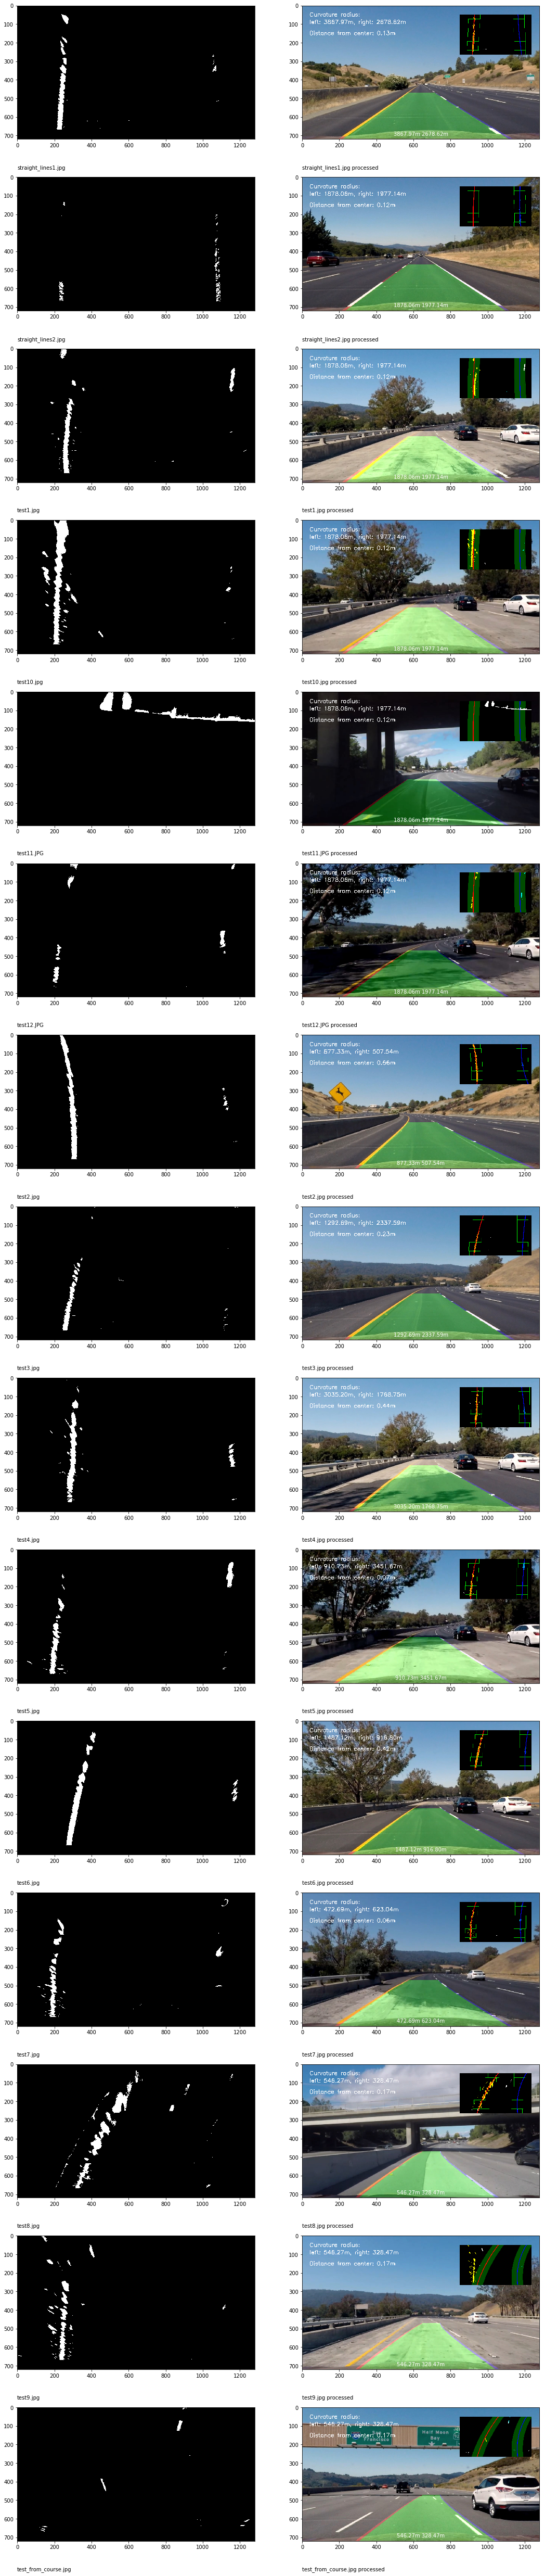

In [18]:
def adjust_thresholds(change=None):
    """
    combiner values: "dir", "mag", None
    """
    r=r_i.value
    g=g_i.value
    b=b_i.value
    h=h_i.value
    l=l_i.value
    s=s_i.value
    y=y_i.value
    u=u_i.value
    v=v_i.value
    h2=h2_i.value
    s2=s2_i.value
    v2=v2_i.value
    sobel_x=sobel_x_i.value
    sobel_y=sobel_y_i.value
    sobel_x_kernel=sobel_y_i.value
    sobel_y_kernel=sobel_y_kernel_i.value
    combiner=combiner_i.value
    mag_or_sobel_range=mag_or_sobel_range_i.value
    dir_range=dir_range_i.value
    inrange_min1 = inrange_min1_i.value
    inrange_min2 = inrange_min2_i.value
    inrange_min3 = inrange_min3_i.value
    inrange_max1 = inrange_max1_i.value
    inrange_max2 = inrange_max2_i.value
    inrange_max3 = inrange_max3_i.value
    
    ip = ImagePipeline(input_color='bgr')
    # ip.calibrate(glob.glob('camera_cal/calibration*.jpg'))
    ip.mtx = mtx
    ip.dist = dist

    src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])

    dst = np.float32([[ 120.,  720.],
                      [ 120.,    0.],
                      [ 1160.,    0.],
                      [ 1160.,  720.]])

    ip.set_perspective(src, dst)
            
    if combiner == 'dir':
        t = Threshold(trange=dir_range, crop_b=50)
    else:
        t = Threshold(trange=mag_or_sobel_range, crop_b=50)
        
    cc = []
    if r:
        cc.append('r')
    if g:
        cc.append('g')
    if b:
        cc.append('b')
    if h:
        cc.append('h')
    if l:
        cc.append('l')
    if s:
        cc.append('s')
    if y:
        cc.append('y')
    if u:
        cc.append('u')
    if v:
        cc.append('v')
    if h2:
        cc.append('h2')
    if s2:
        cc.append('s2')
    if v2:
        cc.append('v2')
    if len(cc) == 3:
        t.add(Color(cc, in_range=((inrange_min1, inrange_min2, inrange_min3),
                                  (inrange_max1, inrange_max2, inrange_max3))))

        if sobel_x:
            t.add(Sobel('x', kernel=sobel_x_kernel))

        if sobel_y:
            t.add(Sobel('y', kernel=sobel_y_kernel))

        if combiner == 'dir':
            t.add(Direction())
        elif combiner == 'mag':
            t.add(Magnitude())

        ip.add(t)
        c = Combinator(f=(lambda ths: np.where((ths[0] >= 1))))
        ip.add(c)
        f = FindLinesSlidingWindows(always_recalculate=True)
        ip.add(f)

        a = Annotate(f)
        ip.add(a)

        all_images = glob.glob('test_images/*.jpg')
        img_paths = all_images[:]
#         img_paths = ['test_images/test9.jpg', 'test_images/test8.jpg', 'test_images/test_from_course.jpg', 'test_images/test7.jpg', 'test_images/test4.jpg']

        cols = 2
        rows = math.ceil(float(len(img_paths))/cols)*2
        fig = plt.figure(figsize=(18, 6*rows))
        i = 0
        for fname in img_paths:
            ax = fig.add_subplot(rows, cols, i+1)
            name = os.path.basename(fname)
            img = cv2.imread(fname)
            img = cv2.resize(img, (1280, 720))
            processed = ip.process(img)

            plt.imshow(t.img, cmap='gray')
            plt.text(0, 880, name)
            i+=1

            ax = fig.add_subplot(rows, cols, i+1)
            plt.imshow(processed)

            plt.text(0, 880, "{} processed".format(name))
            plt.text(640, 700, "{:.2f}m {:.2f}m".format(f.left_curverad_m, f.right_curverad_m), color='white', ha='center')
            i+=1
#         clear_output(True)
    else:
        clear_output(True)
        print("Choose three colors")


r_i = Checkbox(description='r', value=False)
g_i = Checkbox(description='g', value=False)
b_i = Checkbox(description='b', value=False)
h_i = Checkbox(description='h', value=True )
l_i = Checkbox(description='l', value=True)
s_i = Checkbox(description='s', value=True)
y_i = Checkbox(description='y', value=False)
u_i = Checkbox(description='u', value=False)
v_i = Checkbox(description='v', value=False)
h2_i = Checkbox(description='h2', value=False)
s2_i = Checkbox(description='s2', value=False)
v2_i = Checkbox(description='v2', value=False)
inrange_min1_i = IntSlider(description='inrange min 1', min=0, max=255, step=1, value=20)
inrange_min2_i = IntSlider(description='inrange min 2', min=0, max=255, step=1, value=100)
inrange_min3_i = IntSlider(description='inrange min 3', min=0, max=255, step=1, value=12)
inrange_max1_i = IntSlider(description='inrange max 1', min=1, max=255, step=1, value=138)
inrange_max2_i = IntSlider(description='inrange max 2', min=1, max=255, step=1, value=255)
inrange_max3_i = IntSlider(description='inrange max 3', min=1, max=255, step=1, value=255)
sobel_x_i = Checkbox(description='sobel x', value=False)
sobel_y_i = Checkbox(description='sobel y', value=False)
sobel_x_kernel_i = IntSlider(description='sobel x kernel', min=1, max=31, step=2, value=3)
sobel_y_kernel_i = IntSlider(description='sobel y kernel', min=1, max=31, step=2, value=3)
combiner_i = RadioButtons(description='combiner', options=[None, 'mag', 'dir'], value=None)
mag_or_sobel_range_i = IntRangeSlider(description='color, mag, or sobel range', min=0, max=512, step=1, value=[1, 255])
dir_range_i = FloatRangeSlider(description='dir range', min=0, max=np.pi / 2, step=0.01,value=[0.7, 1.3])

r_i.observe(adjust_thresholds, 'value')
g_i.observe(adjust_thresholds, 'value')
b_i.observe(adjust_thresholds, 'value')
h_i.observe(adjust_thresholds, 'value')
l_i.observe(adjust_thresholds, 'value')
s_i.observe(adjust_thresholds, 'value')
y_i.observe(adjust_thresholds, 'value')
u_i.observe(adjust_thresholds, 'value')
v_i.observe(adjust_thresholds, 'value')
h2_i.observe(adjust_thresholds, 'value')
s2_i.observe(adjust_thresholds, 'value')
v2_i.observe(adjust_thresholds, 'value')
inrange_min1_i.observe(adjust_thresholds, 'value')
inrange_min2_i.observe(adjust_thresholds, 'value')
inrange_min3_i.observe(adjust_thresholds, 'value')
inrange_max1_i.observe(adjust_thresholds, 'value')
inrange_max2_i.observe(adjust_thresholds, 'value')
inrange_max3_i.observe(adjust_thresholds, 'value')
sobel_x_i.observe(adjust_thresholds, 'value')
sobel_y_i.observe(adjust_thresholds, 'value')
sobel_x_kernel_i.observe(adjust_thresholds, 'value')
sobel_y_kernel_i.observe(adjust_thresholds, 'value')
combiner_i.observe(adjust_thresholds, 'value')
mag_or_sobel_range_i.observe(adjust_thresholds, 'value')
dir_range_i.observe(adjust_thresholds, 'value')

display(r_i, g_i, b_i, h_i, l_i, s_i, y_i, u_i, v_i, h2_i, s2_i, v2_i,
        inrange_min1_i, inrange_min2_i, inrange_min3_i,
        inrange_max1_i, inrange_max2_i, inrange_max3_i)
adjust_thresholds()

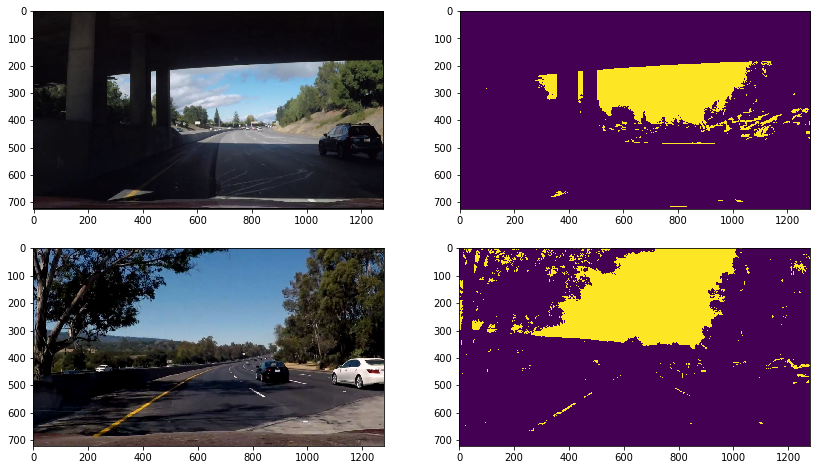

In [12]:
def find_color_hls(change=None):
    inrange_min1 = inrange_min1_i.value
    inrange_min2 = inrange_min2_i.value
    inrange_min3 = inrange_min3_i.value
    inrange_max1 = inrange_max1_i.value
    inrange_max2 = inrange_max2_i.value
    inrange_max3 = inrange_max3_i.value
    
#     img_paths = ['test_images/test9.jpg', 'test_images/test8.jpg', 'test_images/test_from_course.jpg', 'test_images/test7.jpg', 'test_images/test4.jpg']
    img_paths = ['test_images/test11.jpg', 'test_images/test12.jpg']
#     img_paths = glob.glob('test_images/*.jpg')
    fig = plt.figure(figsize=(14, len(img_paths)*4))
    rows = len(img_paths)
    cols = 2
    i = 1

    for img_path in img_paths:
        ax = fig.add_subplot(rows, cols, i)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        i += 1

        ax = fig.add_subplot(rows, cols, i)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        img = cv2.inRange(img, (inrange_min1, inrange_min2, inrange_min3), (inrange_max1, inrange_max2, inrange_max3))
        plt.imshow(img)
        i += 1

    clear_output(True)

inrange_min1_i = IntSlider(description='inrange min 1', min=0, max=255, step=1, value=20)
inrange_min2_i = IntSlider(description='inrange min 2', min=0, max=255, step=1, value=100)
inrange_min3_i = IntSlider(description='inrange min 3', min=0, max=255, step=1, value=12)
inrange_max1_i = IntSlider(description='inrange max 1', min=1, max=255, step=1, value=138)
inrange_max2_i = IntSlider(description='inrange max 2', min=1, max=255, step=1, value=255)
inrange_max3_i = IntSlider(description='inrange max 3', min=1, max=255, step=1, value=255)

inrange_min1_i.observe(find_color_hls, 'value')
inrange_min2_i.observe(find_color_hls, 'value')
inrange_min3_i.observe(find_color_hls, 'value')
inrange_max1_i.observe(find_color_hls, 'value')
inrange_max2_i.observe(find_color_hls, 'value')
inrange_max3_i.observe(find_color_hls, 'value')

display(inrange_min1_i, inrange_min2_i, inrange_min3_i,
        inrange_max1_i, inrange_max2_i, inrange_max3_i)
find_color_hls()